In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from hyperopt import fmin
from xgboost import XGBClassifier
from hyperopt import hp, tpe, Trials, STATUS_OK

import utils_notebook
import utils_train

%load_ext autoreload
%autoreload 2

In [13]:
train_data = pd.read_csv(os.path.join('..', 'data', 'training.csv'))
train_data_imputation = train_data.copy()
train_data.tail()

,price,rrp_price,discount,store_region,store_open,store_visitors,customer_age,customer_gender,staff_sales,staff_experience,staff_age,in_store_promotions,sales
4995,447.31,44731.0,0.000000,north,1,993.413094,50.0,female,0,3,33.0,NaN,0
4996,463.84,46384.0,0.423968,east,1,918.292221,58.0,male,1,22,44.0,1.0,1
4997,419.91,41991.0,0.593226,north,1,960.139885,NaN,NaN,1,8,43.0,NaN,1
4998,468.79,46879.0,0.201646,north,1,976.294908,NaN,female,0,6,37.0,NaN,0
4999,472.91,47291.0,0.000000,west,1,908.478967,59.0,female,0,22,43.0,NaN,0


## Missing Data Imputation

#### Imputation of store visitors
* The number of store visitors do not vary significantly accross shops in different regions. 
* We will impute the missing values using the mean store visitors corresponding regions to which the shop belongs.

In [14]:
train_data_imputation['store_visitors'] = utils_train.impute_column(train_data_imputation,
                                                                       'store_visitors',
                                                                       ['store_region'])

#### Imputation of customer age
* As the candle sticks plotted above between the customer age, store region and gender indicat almost equal distribution within the groups. 
* Therefore the missing values in customer age can be imputed based on subgroups of customer gender and store region.

In [15]:
train_data_imputation['customer_age'] = utils_train.impute_column(train_data_imputation,
                                                                    'customer_age',
                                                                    ['store_region', 'customer_gender'])

#### Imputation of Discount
From the plot above it is intutive that the distribution of the discount variable is identical in all the store regions. 

In [16]:
train_data_imputation['discount'] = utils_train.impute_column(train_data_imputation,
                                                                'discount',
                                                                ['store_region'])

#### Dropping Columns and Rows
* Drop column in_store_promotions - Low MIC coefficient across other columns and high missing value ration. In the validation there is only one unique value, therefore no prominent information can be infered from it.
* Drop column store_open - Only one unique value.
* Drop column rrp_price - Identical to price column.
* Drop rows customer_gender - Being a binary type of information imputing it would add bias due to the altered distribution. Insufficient additional information about customer for imputation.

In [17]:
utils_notebook.missing_values_table(train_data_imputation)

Your selected dataframe has 13 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
in_store_promotions,3250,65.0
customer_gender,150,3.0
customer_age,2,0.0


In [18]:
train_data_imputation = train_data_imputation.drop(columns=['in_store_promotions',
                                                            'rrp_price', 'store_open'])
train_data_imputation = train_data_imputation.dropna()

In [19]:
assert len(utils_notebook.missing_values_table(train_data_imputation)) == 0

Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


## Model Training

In [20]:
categorical_cols = ['store_region', 'customer_gender']
dict_label_encoder = defaultdict(preprocessing.LabelEncoder)
train_data_imputation[categorical_cols] = train_data_imputation[categorical_cols]\
                                          .apply(lambda x: dict_label_encoder[x.name].fit_transform(x))

In [21]:
train_x, test_x, train_y, test_y = train_test_split(train_data_imputation.drop(columns=['sales']),
                                                    train_data_imputation['sales'], test_size=0.20)

dict_data_segments = dict()
dict_data_segments['train_x'], dict_data_segments['train_y'], \
dict_data_segments['test_x'], dict_data_segments['test_y'] = train_x, train_y, test_x, test_y

with open(os.path.join('..', 'data', 'data_segments.pkl'), 'wb') as f:
    pickle.dump(dict_data_segments, f)

In [22]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),
    'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
}

trials = Trials()
xgb_hyperparams = fmin(fn = utils_train.xgb_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

xgb_results = utils_train.org_results(trials.trials, xgb_hyperparams, 'XGBoost')
display(xgb_results)

100%|██████████| 150/150 [00:22<00:00,  6.71trial/s, best loss: 0.0]


In [23]:
static_params = {'objective':'binary:logistic'}
static_params.update(xgb_results['parameters'])
static_params['max_depth'] = int(static_params['max_depth'])
static_params['n_estimators'] = int(static_params['n_estimators'])

In [24]:
model_tuned = XGBClassifier(**static_params)
model_tuned.fit(train_x, train_y)

[19:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "m_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.07147524806587753,
              m_child_weight=4.0, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=950,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

## Model Evaluation

In [25]:
validation_data = pd.read_csv(os.path.join('..', 'data', 'validation.csv'))
assert(len(utils_notebook.missing_values_table(validation_data))) == 0

Your selected dataframe has 13 columns.
There are 0 columns that have missing values.


In [26]:
validation_data.drop(columns=['in_store_promotions',
                              'rrp_price', 'store_open'], inplace=True)

validation_data[categorical_cols] = validation_data[categorical_cols]\
                                    .apply(lambda x: dict_label_encoder[x.name].transform(x))

In [27]:
predict_valid_data = model_tuned.predict(validation_data.drop(columns='sales'))

Accuracy of the model = 51.0


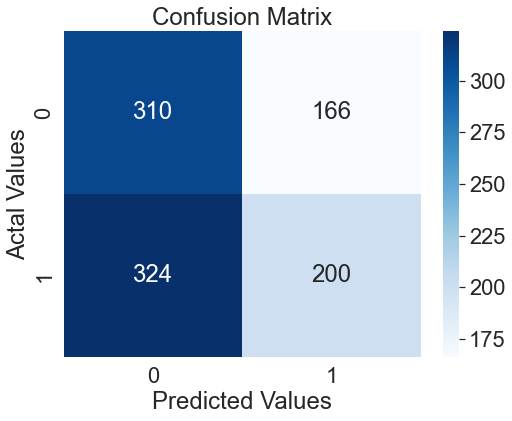

,precision,recall,f1-score,support
0,0.49,0.65,0.56,476
1,0.55,0.38,0.45,524
accuracy,0.51,0.51,0.51,0
macro avg,0.52,0.52,0.50,1000
weighted avg,0.52,0.51,0.50,1000


In [29]:
utils_train.generate_performance_metrics(validation_data['sales'], predict_valid_data)